In [1]:
# source: https://www.kaggle.com/nobletp/panda-keras-baseline

In [2]:
#test: python3 effnB3_mc.py --cnnpar effnB3_gs_test --mfolder effnB3gs
#train: python3 effnB3_mc.py --cnnpar effnB3_gs --mfolder effnB3gs

In [ ]:
DEBUG = False

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os, argparse, sys
sys.path.append("..")
from glob import glob
from random import shuffle
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd 
import json
import skimage.io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('no gpus')

tensorflow version: 2.2.0
no gpus


In [4]:
#import albumentations as albu
# from imgaug import augmenters as iaa
# import imgaug as ia
# ia.seed(1)

In [6]:
import panda_bvv_config
from panda_bvv_config import *

In [8]:
if DEBUG:
    #FOR TEST:
    cnnet = 'effnB3_gs_test'
    model_save_folder = 'effnB3_test'
else:
    #FOR TRAIN:
    ap = argparse.ArgumentParser()
    ap.add_argument('--cnnpar', type=str, help="parameters name", dest = 'cnn_parameters', default = 'effnB2')
    ap.add_argument('--mfolder', help="folder to save model files", dest = 'mfolder', default = 'effnB2_model',\
                    type=str)
                    #("--cnn", type=str, help="training cnn name", dest = 'train_cnn')
    args = vars(ap.parse_args())
    cnnet = args["cnn_parameters"]
    model_save_folder = args["mfolder"]

In [9]:
full_model_save_folder_path = os.path.join(note_path, model_save_folder)
input_parameters = panda_bvv_config.train_dict.get(cnnet)

image_sizey = input_parameters.get('image_sizey')
image_sizex = input_parameters.get('image_sizex')
num_epochs = input_parameters.get('num_epochs')
num_reduceOnPlateu = input_parameters.get('num_reduceOnPlateu')
learn_rate = input_parameters.get('learn_rate')
stop_patience = input_parameters.get('stop_patience')
inp_label_smooth = input_parameters.get('inp_label_smooth')
our_id_label_map = input_parameters.get('id_label_map')
class_weights_ = input_parameters.get('class_weights')
output_bias = tf.keras.initializers.Constant(input_parameters.get('output_bias'))
BS = input_parameters.get('BS')
s_per_epoch = input_parameters.get('s_per_epoch')
val_steps = input_parameters.get('val_steps')
model_name = input_parameters.get('model_name')
checkpoint_name = input_parameters.get('checkpoint_name')
weights_file = input_parameters.get('weights_file')
file_for_struct = input_parameters.get('file_for_struct')
file_for_weights = input_parameters.get('file_for_weights')
history_file = input_parameters.get('history_file')
save_plot_file = input_parameters.get('save_plot_file')
num_logits = input_parameters.get('num_logits')
from_folder_train = os.path.join(base_path, input_parameters.get('from_folder_train'))
from_folder_val = input_parameters.get('from_folder_val')
if input_parameters.get('bestmodel_weights'): bestmodel_weights = input_parameters.get('bestmodel_weights')
input_shape_ =(image_sizey, image_sizex , 3)
TrDataGen = input_parameters.get('trdatagen') 
ValDataGen = input_parameters.get('valdatagen') 


In [10]:
from tensorflow_addons.metrics import  CohenKappa
kappa_keras = CohenKappa(num_classes=num_logits,weightage='quadratic')

In [12]:
print('CNN input parameters:\n') 
for k, v in input_parameters.items():
    if k != 'id_label_map':
        print('{}: {}'.format(k, v))

CNN input parameters:

image_sizey: 320
image_sizex: 320
num_epochs: 2
num_reduceOnPlateu: 6
learn_rate: 0.0001
stop_patience: 18
inp_label_smooth: 0.01
BS: 4
s_per_epoch: 8
val_steps: 3
class_weights: {0: 3.67082, 1: 3.982, 2: 7.90469, 3: 8.5475, 4: 8.4996, 5: 8.6732}
output_bias: [1. 1. 1. 1. 1. 1.]
model_name: model_panda.h5
checkpoint_name: model_effnB3_panda_check
weights_file: efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5
bestmodel_weights: None
level0_file: effnB3_check20_best_level0_weights.npy
file_for_struct: model_effnB3_panda_struct.json
file_for_weights: model_effnB3_panda_weights
history_file: history_effnB3.json
save_plot_file: plot_edu_effnb3.png
from_folder_train: gs_proc_inv
from_folder_val: None
num_logits: 4
trdatagen: <function classic_train_datagen at 0x7f95f97390d0>
valdatagen: <function classic_val_datagen at 0x7f95f9739158>


In [13]:
#full_model_save_folder_path = os.path.join(note_path, model_save_folder)
if not os.path.exists(full_model_save_folder_path):
    print("[INFO] 'creating {}' directory".format(model_save_folder))
    os.makedirs(full_model_save_folder_path)
model_name = os.path.join(full_model_save_folder_path, model_name)
checkpoint_name = os.path.join(full_model_save_folder_path, checkpoint_name)

weights_file = os.path.join(note_path, weights_file) #!:not the same path

file_for_struct = os.path.join(full_model_save_folder_path, file_for_struct)
file_for_weights = os.path.join(full_model_save_folder_path, file_for_weights)
history_file = os.path.join(full_model_save_folder_path, history_file)
save_plot_file_main = os.path.join(full_model_save_folder_path, 'acc_' + save_plot_file)
save_plot_file_kappa = os.path.join(full_model_save_folder_path, 'kappa_' + save_plot_file)

In [14]:
train_datagen = TrDataGen(
        train_cnn,
        image_sizey, image_sizex,
        batch_size_= BS,
        shuffle_=True)
val_datagen = ValDataGen(
        valid_cnn,
        image_sizey, 
        image_sizex,
        batch_size_ = BS,
        shuffle_=False)

Found 132 images belonging to 4 classes.
Found 1162 images belonging to 4 classes.


In [16]:
#skimage.io.imshow(tt[0][6])

In [17]:
callbacks_list = [
#         EarlyStopping(
        # Stop training when `val_loss` is no longer improving
#         monitor='val_loss',
#         mode = 'min',
#         min_delta=1e-2,
#         patience=stop_patience,
#         verbose=1,
#         restore_best_weights = True
#         ),
        
        ModelCheckpoint(
        filepath= checkpoint_name +".{epoch:02d}.h5",
        monitor='val_loss',
        mode = 'auto',
        save_weights_only = False,
        save_freq = 'epoch',
        save_best_only=False
        ),
    
        ReduceLROnPlateau(
        monitor='val_loss',
        factor=.1,
        patience = num_reduceOnPlateu,
        verbose=1,
        min_lr=1e-7
        )
]

In [18]:
#tf.compat.v1.disable_eager_execution()

In [19]:
bottleneck = efn.EfficientNetB3(
    input_shape=input_shape_,
    weights= weights_file,
    include_top=False, 
    pooling='avg'
)
bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
model = Sequential()
model.add(bottleneck)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(num_logits, activation='sigmoid'))

In [20]:
if input_parameters.get('bestmodel_weights'): 
    try:
        model.load_weights(bestmodel_weights)
    except Exception as ee:
        print(ee)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [22]:
opt =  tf.keras.optimizers.Adam(lr=learn_rate, decay=learn_rate / num_epochs)

In [23]:
model.compile(
    loss  = tf.keras.losses.BinaryCrossentropy(label_smoothing = inp_label_smooth),
    optimizer=opt,
    metrics=['accuracy', kappa_keras]
)

In [24]:
history = model.fit_generator(
    train_datagen,
    steps_per_epoch=s_per_epoch,
    validation_data=val_datagen,
    validation_steps=val_steps,
    class_weight=class_weights_,
    callbacks=callbacks_list,
    epochs=num_epochs,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
8/8 [==============================] - 27s 3s/step - loss: 4.4373 - accuracy: 0.3125 - cohen_kappa: 0.2899 - val_loss: 0.6121 - val_accuracy: 0.1667 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/2
8/8 [==============================] - 23s 3s/step - loss: 5.1108 - accuracy: 0.1562 - cohen_kappa: 0.2195 - val_loss: 0.6450 - val_accuracy: 0.2500 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04


In [25]:
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)


In [26]:
model.save_weights(file_for_weights, save_format="h5")

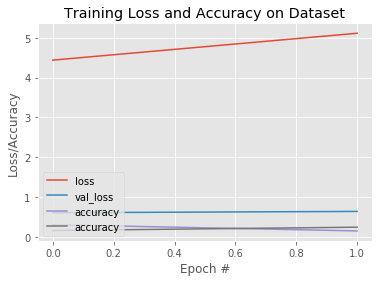

In [28]:
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, num_epochs), history.history['loss'], label='loss')
plt.plot(np.arange(0, num_epochs), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs),history.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, num_epochs),history.history['val_accuracy'], label='accuracy')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(save_plot_file_main)

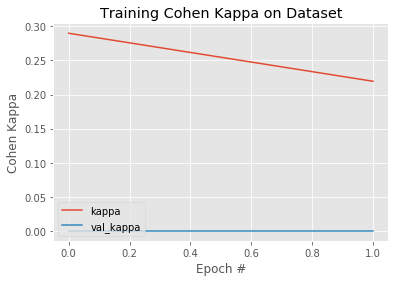

In [29]:
#kappa
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, num_epochs), history.history['cohen_kappa'], label='kappa')
plt.plot(np.arange(0, num_epochs), history.history['val_cohen_kappa'], label='val_kappa')

plt.title("Training Cohen Kappa on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Cohen Kappa")
plt.legend(loc="lower left")
plt.savefig(save_plot_file_kappa)

In [37]:
import os
module_name = 'effnB3_sigm_flow_from_folders'

os.system('jupyter nbconvert --to python ' + module_name + '.ipynb')
with open(module_name + '.py', 'r') as f:
    lines = f.readlines()
with open(module_name + '.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to python' in line:
            break
        else:
            f.write(line)